In [2]:
percent_optimal_action = 0
average_reward = 0

number_arms = 10

# each action value a is a normal (Gaussian) distribution with mean 0 and variance 1
# actual reward Rt = q(At) + noise
# noise is normally distributed w mean 0 and variance 1


In [3]:
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np

In [4]:
bandits_df = pd.DataFrame(data=[])
bandits_list = [] # hold all 10 bandits
# pick max bandit


In [5]:
n = 10
for i in range(n):
    bandit = random.gauss(mu=0,sigma=1)
    bandits_list.append(bandit)


In [1]:
class Agent:
    def __init__(self, bandit, policy, prior=0):
        self.k = bandit.k
        self.policy = policy
        self.prior = prior # optimistic initial values are the same (a priori)
        self.estimated_values = self.prior * np.ones(self.k) # if prior != 0, then we need to initialize the agent's lever_pulls to 1
        self.lever_pulls = np.zeros(self.k) if self.prior == 0 else np.ones(self.k) 
        print("Agent's prior", self.prior, " their lever_pulls:", self.lever_pulls)

        self.t = 0
        self.last_action = None
        bandit.print_actual_values()
    
    def choose(self, is_first_time):
        # choose one action to take depending on what policy this agent adopts
        action = self.policy.take_action(self, is_first_time) # pass in the agent state to the policy
        self.last_action = action
        return action
    def adjust(self, reward):
        # adjust priors after the reward of an action

        self.lever_pulls[self.last_action] += 1
        Q = self.estimated_values[self.last_action]
        step_size = (1.0/self.lever_pulls[self.last_action])

        updated_estimated_lever_value = Q + (step_size) * (reward - Q)
        self.estimated_values[self.last_action] = updated_estimated_lever_value
        self.t += 1
        
    def reset(self):
        self.estimated_values = self.prior * np.ones(self.k)
        self.lever_pulls = np.zeros(self.k) if self.prior == 0 else np.ones(self.k) 
        self.t = 0
        self.last_action = None

    def __str__(self) -> str:
        representation_string = ""
        representation_string += self.policy.__str__()
        if self.prior != 0:
            representation_string = "Optimistic"

        return representation_string
 
class Policy:
    pass

class EpsilonGreedyPolicy(Policy): # TODO: UPDATE THE Optimsitc badnit so that it starts with levers = 1 since it starts w prior of 5, makes sure the 5 isn't being overwritten
    # use a flag if prior != 0
    # TODO: add step-size alpha policy
    def __init__(self, epsilon, prior=0):
        self.prior = prior
        self.epsilon = epsilon
        self.initially_set_levers_to_one = prior != 0 # if prior != 0, then we need to initialize the agent's lever_pulls to 1
    
    def take_action(self, agent, is_first_time=False):
        epsilon_threshold = random.uniform(0,1)
        if epsilon_threshold < self.epsilon:
            # randomly select some lever
            return random.randrange(0, len(agent.estimated_values))
            
        else:
            # greedily select some lever
            action_to_take = np.argmax(agent.estimated_values)
            all_matching_actions = np.where(agent.estimated_values == agent.estimated_values[action_to_take])[0] # if multiple levers have same estimated values, pick one randomly
            # print("matches: ", all_matching_actions)
            if len(all_matching_actions) == 1:
                return action_to_take
            else:
                return np.random.choice(all_matching_actions)
            # if is_first_time:
            #     return random.randrange(0, len(agent.estimated_values))
            
            
        # return agent.estimated_values.index(lever_value)
    def __str__(self) -> str:
        string = "e-Greedy, e = " + str(self.epsilon)
        if self.prior != 0:
            string = "e-Optimistic with prior = %s, e = %s" % str(self.prior), str(self.epsilon)
        return string

class GreedyPolicy(EpsilonGreedyPolicy):
    def __init__(self, prior=0):
        self.prior = prior
        super(GreedyPolicy, self).__init__(0, prior) # Greedy policy is just epsilon-greedy with epsilon = 0
    def __str__(self) -> str:
        string = "Greedy"
        if self.prior != 0:
            string = "Optimistic with prior = " + str(self.prior)
        return string
        

class OptimisticPolicy(GreedyPolicy):
    def __init__(self, prior=5):
        super(GreedyPolicy, self).__init__(0, prior)
    def __str__(self) -> str:
        return "Optimistic Policy"

# class UCBPolicy(Policy):
#     def __init__(self, c=0.01):
#         self.c = c

#     def take_action(self, agent):
#         lever_value = self.get_UCB_max(agent) # argmax thing
#         return agent.estimated_values.index(lever_value)

#     def get_UCB_max(self, agent):
#         current_max = 0
#         for a in range(len(agent.estimated_values)):
#             pass
#         return current_max

class Bandit:
    def __init__(self, k, mu=0, sigma=1, levers=None):
        self.k = k
        self.arms = [0] * k
        self.mu = mu
        self.sigma = sigma
        self.optimal = 0
        self.levers = levers
        self.reset()

    def reset(self):
        self.arms = []
        for lever_num in range(self.k):
            if self.levers:
                lever_mu = self.levers[lever_num][0]
                self.arms.append(lever_mu)
            else:
                self.arms.append(random.gauss(self.mu, self.sigma))
        self.optimal = self.arms.index(max(self.arms))
        # reset all arms to be random Gaussian variabels parameterized by mu, sigma, etc.
        # also get the current optimal value
    
    def print_actual_values(self):
        print(self.arms)

    def pull(self, lever):
        # pull one lever of the bandit, return this lever's reward (gaussian). Also return if this was the optimal choice
        
        if self.levers:
            lever_sigma = self.levers[lever][1]
            reward = random.gauss(self.arms[lever], sigma=lever_sigma)
        else:
            reward = random.gauss(self.arms[lever], sigma=1) # gaussian distribution centered around RV's (arm's) mean, variance 1 (TODO: is this correct?)

        is_optimal = self.optimal == lever
        return reward, is_optimal
        


In [7]:
import numpy as np

In [4]:
class Driver:
    def __init__(self, bandit, agents):
        self.bandit = bandit
        self.agents = agents

    def run_once(self, trials, experiments, which_agent=3):
        total_reward = np.zeros((trials, len(self.agents))) # trials by average reward
        num_optimal = np.zeros((trials, len(self.agents))) # trials by % optimal action

        
        self.reset()
        for t in range(trials):
            # update each agent
            for agent_num, agent in enumerate(self.agents):
                lever = agent.choose(t == 0)
                reward, is_optimal = self.bandit.pull(lever)
                agent.adjust(reward)

                total_reward[t, agent_num] += reward
                if is_optimal:
                    num_optimal[t, agent_num] += 1
            print(self.agents[which_agent].lever_pulls)
            print(self.agents[which_agent].estimated_values)
        # print(e)
        
        
        # print(self.agents[which_agent].estimated_values)
        
        return self.agents[which_agent].estimated_values, total_reward / experiments, num_optimal / experiments # avg reward, pct optimal
    def run(self, trials, experiments):
        total_reward = np.zeros((trials, len(self.agents))) # trials by average reward
        num_optimal = np.zeros((trials, len(self.agents))) # trials by % optimal action

        for e in range(experiments):
            self.reset()
            for t in range(trials):
                # update each agent
                for agent_num, agent in enumerate(self.agents):
                    lever = agent.choose(t == 0)
                    reward, is_optimal = self.bandit.pull(lever)
                    agent.adjust(reward)

                    total_reward[t, agent_num] += reward
                    if is_optimal:
                        num_optimal[t, agent_num] += 1
            
            print(e)
            
            if (e == 0):
                if len(self.agents) == 3:
                    print(self.agents[3].estimated_values)
        return total_reward / experiments, num_optimal / experiments # avg reward, pct optimal
    def reset(self):
        for a in self.agents:
            a.reset()

    def plot(self, scores: np.array, optimal: np.array):
        # create plotting software here
        fig, ax = plt.subplots()
        # ax.plot(scores)
        for reward in scores.shape[0]:
            ax.plot(reward)
        # for a in self.agents:
        #     ax.plot(a.estimated_values)
        # % optimal plot

        

In [22]:
# examples
experiments = 500
trials = 1000

# levers = [[0,10],[0,1],[-2,4],[5,3]]
# bandit = Bandit(k=len(levers), levers=levers)

bandit = Bandit(10) # create 10-armed bandit w normal variables
agents = [
    Agent(bandit, policy=GreedyPolicy()),
    Agent(bandit, policy=EpsilonGreedyPolicy(0.01)),
    Agent(bandit, EpsilonGreedyPolicy(0.1)),
    Agent(bandit, policy=GreedyPolicy(), prior=5) # optimistic bandit
]

env = Driver(bandit, agents)
scores, optimal = env.run(trials, experiments)

# estimated_values, scores, optimal = env.run_once(trials, experiments, 3)
# env.plot(scores, optimal)

Agent's prior 0  their lever_pulls: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.3960625725234867, 0.7171386389916365, -0.6237683051770676, -1.8733642077024255, 1.4608444002935375, 0.9288519832355908, 0.8587333786179431, 0.7315545151663055, -0.45961324074421855, -0.525609531440121]
Agent's prior 0  their lever_pulls: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.3960625725234867, 0.7171386389916365, -0.6237683051770676, -1.8733642077024255, 1.4608444002935375, 0.9288519832355908, 0.8587333786179431, 0.7315545151663055, -0.45961324074421855, -0.525609531440121]
Agent's prior 0  their lever_pulls: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.3960625725234867, 0.7171386389916365, -0.6237683051770676, -1.8733642077024255, 1.4608444002935375, 0.9288519832355908, 0.8587333786179431, 0.7315545151663055, -0.45961324074421855, -0.525609531440121]
Agent's prior 5  their lever_pulls: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.3960625725234867, 0.7171386389916365, -0.6237683051770676, -1.8733642077024255, 1.4608444002935375, 0.9288

In [24]:
estimated_values

array([ 0.51355008, -1.38740853, -2.48894252,  1.49177804, -0.5170391 ,
       -1.87778077,  2.02054773, -1.36453958, -1.00074829,  1.18200083])

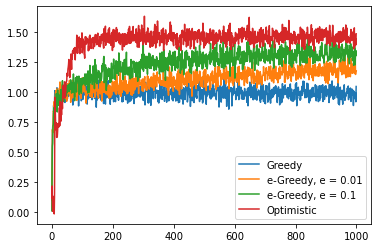

In [23]:
fig, ax = plt.subplots()
        # ax.plot(scores)
for agent_num in range(scores.shape[1]):
    ax.plot(scores[:, agent_num], label=agents[agent_num].__str__())
ax.legend()

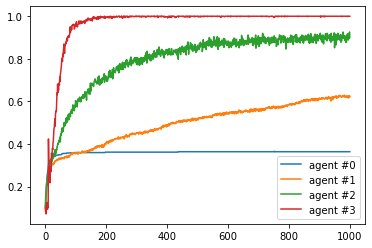

In [7]:
fig, ax = plt.subplots()
        # ax.plot(scores)
for agent_num in range(optimal.shape[1]):
    ax.plot(optimal[:, agent_num], label="agent #" + str(agent_num))

ax.legend()

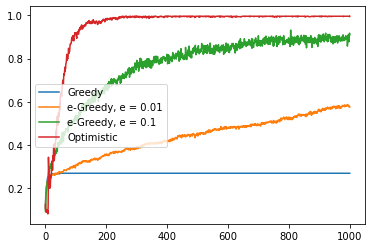

In [24]:
fig, ax = plt.subplots()
        # ax.plot(scores)
for agent_num in range(optimal.shape[1]):
    ax.plot(optimal[:, agent_num], label=agents[agent_num].__str__())

ax.legend()